In [ ]:
#pip install -U scikit-learn scipy matplotlib

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import scipy
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
test=pd.read_csv('/content/gdrive/MyDrive/Untitled folder/test_koRSKBP.csv')
train=pd.read_csv('/content/gdrive/MyDrive/Untitled folder/train_BRCpofr.csv')

In [4]:
train_df=pd.concat([train,test])

In [5]:
train_df['log_claim_amount'] = np.log(train_df['claim_amount']+1)

In [6]:
# Data Preprocessing
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

replace_with_thresholds(train_df, "claim_amount")
replace_with_thresholds(train_df, "vintage")
train_df["total_claimed_amt"] = train_df["claim_amount"] * train_df["vintage"]

In [7]:
#train['log_claim_amount']=train['log_claim_amount'].astype(str)
#display(train[train['log_claim_amount']=='-inf'])

In [8]:
train.isnull().sum().sum()

0

In [9]:
train_df.describe()

,id,marital_status,vintage,claim_amount,cltv,log_claim_amount,total_claimed_amt
count,148987.000000,148987.000000,148987.000000,148987.000000,89392.000000,148987.000000,148987.000000
mean,74494.000000,0.576064,4.605523,4358.303201,97952.828978,6.814236,20130.130025
std,43008.986615,0.494182,2.287299,3272.692800,90613.814793,3.408191,19635.844301
min,1.000000,0.000000,0.000000,0.000000,24828.000000,0.000000,0.000000
25%,37247.500000,0.000000,3.000000,2402.000000,52836.000000,7.784473,3738.000000
50%,74494.000000,1.000000,5.000000,4095.000000,66396.000000,8.317766,16832.000000
75%,111740.500000,1.000000,6.000000,6098.000000,103440.000000,8.715880,30184.000000
max,148987.000000,1.000000,8.000000,32534.000000,724068.000000,10.390072,260272.000000


In [10]:
train['type_of_policy'].value_counts()

Platinum    47796
Silver      21010
Gold        20586
Name: type_of_policy, dtype: int64

In [11]:
train_df['income'].replace(['5L-10L', '2L-5L','More than 10L','<=2L'],
                        [5,2,10,1], inplace=True)
train_df['gender'].replace(['Male', 'Female'],
                        [0,1], inplace=True)
train_df['area'].replace(['Urban', 'Rural'],
                        [0,1], inplace=True)
train_df['qualification'].replace(['High School', 'Bachelor','Others'],
                        [0,1,2], inplace=True)
train_df['num_policies'].replace(['More than 1', '1'],
                        [0,1], inplace=True)
train_df['policy'].replace(['A', 'B','C'],
                        [0,1,2], inplace=True)
train_df['type_of_policy'].replace(['Platinum', 'Silver','Gold'],
                        [0,1,2], inplace=True)

In [12]:
for i in range(2,6):
    train_df['cltv'+'_lag_'+str(i)]=train_df['cltv'].rolling(i).mean().shift(i).fillna(0)
    #train_df['cltv'+'_expand_'+str(i)]=train_df['cltv'].expanding(i).mean(i).fillna(0)

In [13]:
train=train_df[:89392]
test=train_df[89392:]

In [14]:
len(test)

59595

In [15]:
train.corr()

,id,gender,area,qualification,income,marital_status,vintage,claim_amount,num_policies,policy,type_of_policy,cltv,log_claim_amount,total_claimed_amt,cltv_lag_2,cltv_lag_3,cltv_lag_4,cltv_lag_5
id,1.000000,0.000215,-0.000073,0.005111,0.007110,0.000171,-0.005824,0.003634,0.004105,0.000395,0.003816,-0.004223,0.000775,0.000411,-0.005887,-0.007085,-0.008068,-0.008937
gender,0.000215,1.000000,0.042516,-0.028010,-0.007137,-0.070468,-0.005827,-0.049773,-0.052871,-0.009049,0.010051,0.001318,-0.056379,-0.045729,0.003345,0.004701,-0.001556,-0.004793
area,-0.000073,0.042516,1.000000,0.065427,0.239859,0.048739,-0.001145,-0.451054,0.121898,0.107123,0.002121,-0.133107,-0.479301,-0.343947,0.000104,-0.003061,-0.001370,-0.001394
qualification,0.005111,-0.028010,0.065427,1.000000,0.014792,0.015754,0.017561,-0.066250,0.030235,0.037434,0.022338,-0.027818,-0.059135,-0.038107,0.002967,-0.000012,0.002649,0.000765
income,0.007110,-0.007137,0.239859,0.014792,1.000000,0.022096,-0.014831,-0.183323,0.061823,-0.027849,0.009785,-0.069553,-0.186021,-0.146197,-0.004164,-0.002812,-0.004524,-0.004518
marital_status,0.000171,-0.070468,0.048739,0.015754,0.022096,1.000000,-0.011686,-0.114924,0.082363,-0.014709,0.016893,-0.077744,-0.071312,-0.091229,0.002533,0.000520,-0.000817,0.000549
vintage,-0.005824,-0.005827,-0.001145,0.017561,-0.014831,-0.011686,1.000000,0.009579,-0.050699,0.043822,0.005177,0.020608,0.004698,0.506117,-0.003724,-0.001973,-0.003042,-0.005829
claim_amount,0.003634,-0.049773,-0.451054,-0.066250,-0.183323,-0.114924,0.009579,1.000000,-0.155281,-0.106845,0.002588,0.180344,0.741341,0.777927,-0.004420,-0.007708,-0.002072,0.002142
num_policies,0.004105,-0.052871,0.121898,0.030235,0.061823,0.082363,-0.050699,-0.155281,1.000000,0.009837,0.032327,-0.360414,-0.137651,-0.141744,0.003933,0.004426,0.001964,-0.001388
policy,0.000395,-0.009049,0.107123,0.037434,-0.027849,-0.014709,0.043822,-0.106845,0.009837,1.000000,0.043972,-0.012005,-0.108573,-0.059842,0.001744,-0.001871,-0.003841,-0.005079


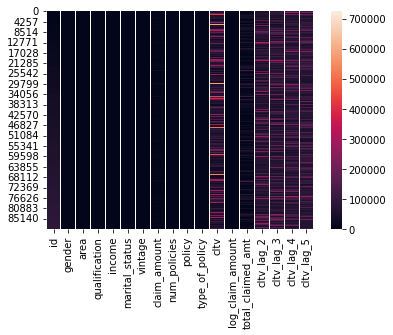

In [16]:
hm = sns.heatmap(data = train) 
# displaying the plotted heatmap
plt.show()

In [17]:
test=test.drop(['cltv'],axis=1)

In [18]:
#train['log_claim_amount'] = np.log(train.claim_amount)
#train['log_cltv'] = np.log(train.cltv)

In [19]:
def random_forest_importance_matrix(X, model):    
#     X = training_data
#     X = X[X.columns.drop(list(X.filter(regex='Lag_')))]
  
    feature_list = list(X.columns)
    feature_list.remove("cltv")
    features = np.array(X.drop(['cltv'], axis = 1))
    target = np.array(X['cltv'])
    rf = model
    rf.fit(features, target)
    
    # Get numerical feature importances
    importances = list(rf.feature_importances_)
    # take only those where we have >.80% importance 
    # List of tuples with variable and importance
    feature_importances = [(feature, round(importance, 4)) for feature, importance in zip(feature_list, importances)]
    # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    df = pd.DataFrame(feature_importances, columns =['Variable', 'Importance']) 
    return(df)
  
  
def random_forest_regressor_grid(features,target):  
#     X = X[X.columns.drop(list(X.filter(regex='Lag_')))]
#     features = np.array(X.drop(['Actuals'], axis = 1))
#     target = np.array(X['Actuals'])
  
    rf = RandomForestRegressor()
    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 20, stop = 60, num = 10)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(2, 8, num = 1)]
   # max_depth.append(None)
    # Minimum number of samples required to split 4a node
    min_samples_split = [4]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [2]
    # Method of selecting samples for training each tree
    bootstrap = [True]
    # Create the random grid
    param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'n_jobs':[2]}
    grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)
    grid_search.fit(features, target)

    #X = training_data
   
    
    best_grid = grid_search.best_estimator_    
    return(best_grid)

In [20]:
y = train['cltv']
X = train.drop(['cltv'], axis=1)
try: 
    rf = random_forest_regressor_grid(X,train['cltv'])
except: 
    rf = RandomForestRegressor(bootstrap=True, criterion='squared_error',
              max_depth=6 ,max_features='auto', max_leaf_nodes=None,
               min_samples_leaf=2,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=1000, n_jobs=-1, oob_score=False, random_state=0,
              verbose=1, warm_start=False,min_impurity_decrease = 0.035)
# colstoselect = list(random_forest_importance_matrix(train['cltv'], rf)[0:12]['Variable'])
# features = trian[X]
# print(random_forest_importance_matrix(train['cltv'], rf)[0:10])
model_rf = rf.fit(X,y)
importances = model_rf.feature_importances_
important_features_dict = {}
for idx, val in enumerate(importances):
    important_features_dict[idx] = val
    important_features_list = sorted(important_features_dict,
                                 key=important_features_dict.get,
                                 reverse=True)
score = cross_val_score(model_rf, X, y, cv=7)
print(score.mean())
        
r_squared = model_rf.score(X, y)      
        
# candidate_max_leaf_nodes = [250]
# #model = LinearRegression()

# for node in candidate_max_leaf_nodes:
#     model = RandomForestRegressor(max_leaf_nodes=node,)
#     model.fit(X, y)
#     score = cross_val_score(model, X, y, cv=10)
#     print(score.mean())

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   58.3s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  4.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   49.8s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  4.2min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.2s

0.15645819132325509


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    1.8s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    3.3s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    4.1s finished


In [28]:
important_features_dict

{0: 0.005998626048613885,
 1: 0.0006955885435196053,
 2: 0.02573444805702406,
 3: 0.00041980895852534084,
 4: 0.0012056082066729177,
 5: 0.007249271090428751,
 6: 0.0007241868673890735,
 7: 0.0656961201918662,
 8: 0.7831230428980273,
 9: 0.015120609402728913,
 10: 0.0017101786483029783,
 11: 0.06404659180277256,
 12: 0.004283453901170715,
 13: 0.006328253302389547,
 14: 0.006203354394950482,
 15: 0.005762340251597483,
 16: 0.005698517434020218}

In [29]:
test['log_claim_amount'] = np.log(test['claim_amount']+1)

# Data Preprocessing
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

replace_with_thresholds(test, "claim_amount")
replace_with_thresholds(test, "vintage")
test["total_claimed_amt"] = test["claim_amount"] * train["vintage"]

In [30]:
test['income'].replace(['5L-10L', '2L-5L','More than 10L','<=2L'],
                        [5,2,10,1], inplace=True)
test['gender'].replace(['Male', 'Female'],
                        [0,1], inplace=True)
test['area'].replace(['Urban', 'Rural'],
                        [0,1], inplace=True)
test['qualification'].replace(['High School', 'Bachelor','Others'],
                        [0,1,2], inplace=True)
test['num_policies'].replace(['More than 1', '1'],
                        [0,1], inplace=True)
test['policy'].replace(['A', 'B','C'],
                        [0,1,2], inplace=True)
test['type_of_policy'].replace(['Platinum', 'Silver','Gold'],
                        [0,1,2], inplace=True)



In [31]:
train.columns

Index(['id', 'gender', 'area', 'qualification', 'income', 'marital_status',
       'vintage', 'claim_amount', 'num_policies', 'policy', 'type_of_policy',
       'cltv', 'log_claim_amount', 'total_claimed_amt', 'cltv_lag_2',
       'cltv_lag_3', 'cltv_lag_4', 'cltv_lag_5'],
      dtype='object')

In [32]:
test.columns

Index(['id', 'gender', 'area', 'qualification', 'income', 'marital_status',
       'vintage', 'claim_amount', 'num_policies', 'policy', 'type_of_policy',
       'log_claim_amount', 'total_claimed_amt', 'cltv_lag_2', 'cltv_lag_3',
       'cltv_lag_4', 'cltv_lag_5'],
      dtype='object')

In [33]:
price = model_rf.predict(test)
test_ids = test['id']
submission = pd.DataFrame({
    "id": test_ids,
    "cltv": price
})

submission.to_csv("submission_4.csv", index=False)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    1.2s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    2.2s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    2.7s finished


In [36]:
submission.head(10)

,id,cltv
0,89393,93540.111601
1,89394,130526.777394
2,89395,120791.001161
3,89396,113413.347196
4,89397,202268.319939
5,89398,171170.468781
6,89399,149452.533454
7,89400,166567.326306
8,89401,148243.518106
9,89402,171242.793125


In [39]:
from sklearn.metrics import r2_score
y = train['cltv'][0:59595]
f = submission['cltv']
r2 = r2_score(y, f)
print('r2 score for a worse model is', r2)

r2 score for a worse model is -0.41533235700321747


In [40]:
import numpy
corr_matrix = numpy.corrcoef(y, f)
corr = corr_matrix[0,1]
R_sq = corr**2
R_sq

0.00011984955187888708

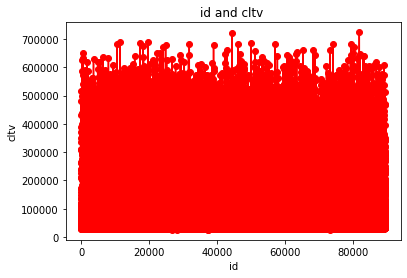

In [41]:
x_axis=train['id']
y_axis=train['cltv']
plt.plot(x_axis, y_axis, color='red', marker='o')
plt.title('id and cltv ')
plt.xlabel('id')
plt.ylabel('cltv')
plt.rcParams["figure.figsize"] = (30,20)
# plt.figure(figsize=(10, 20))
plt.show()

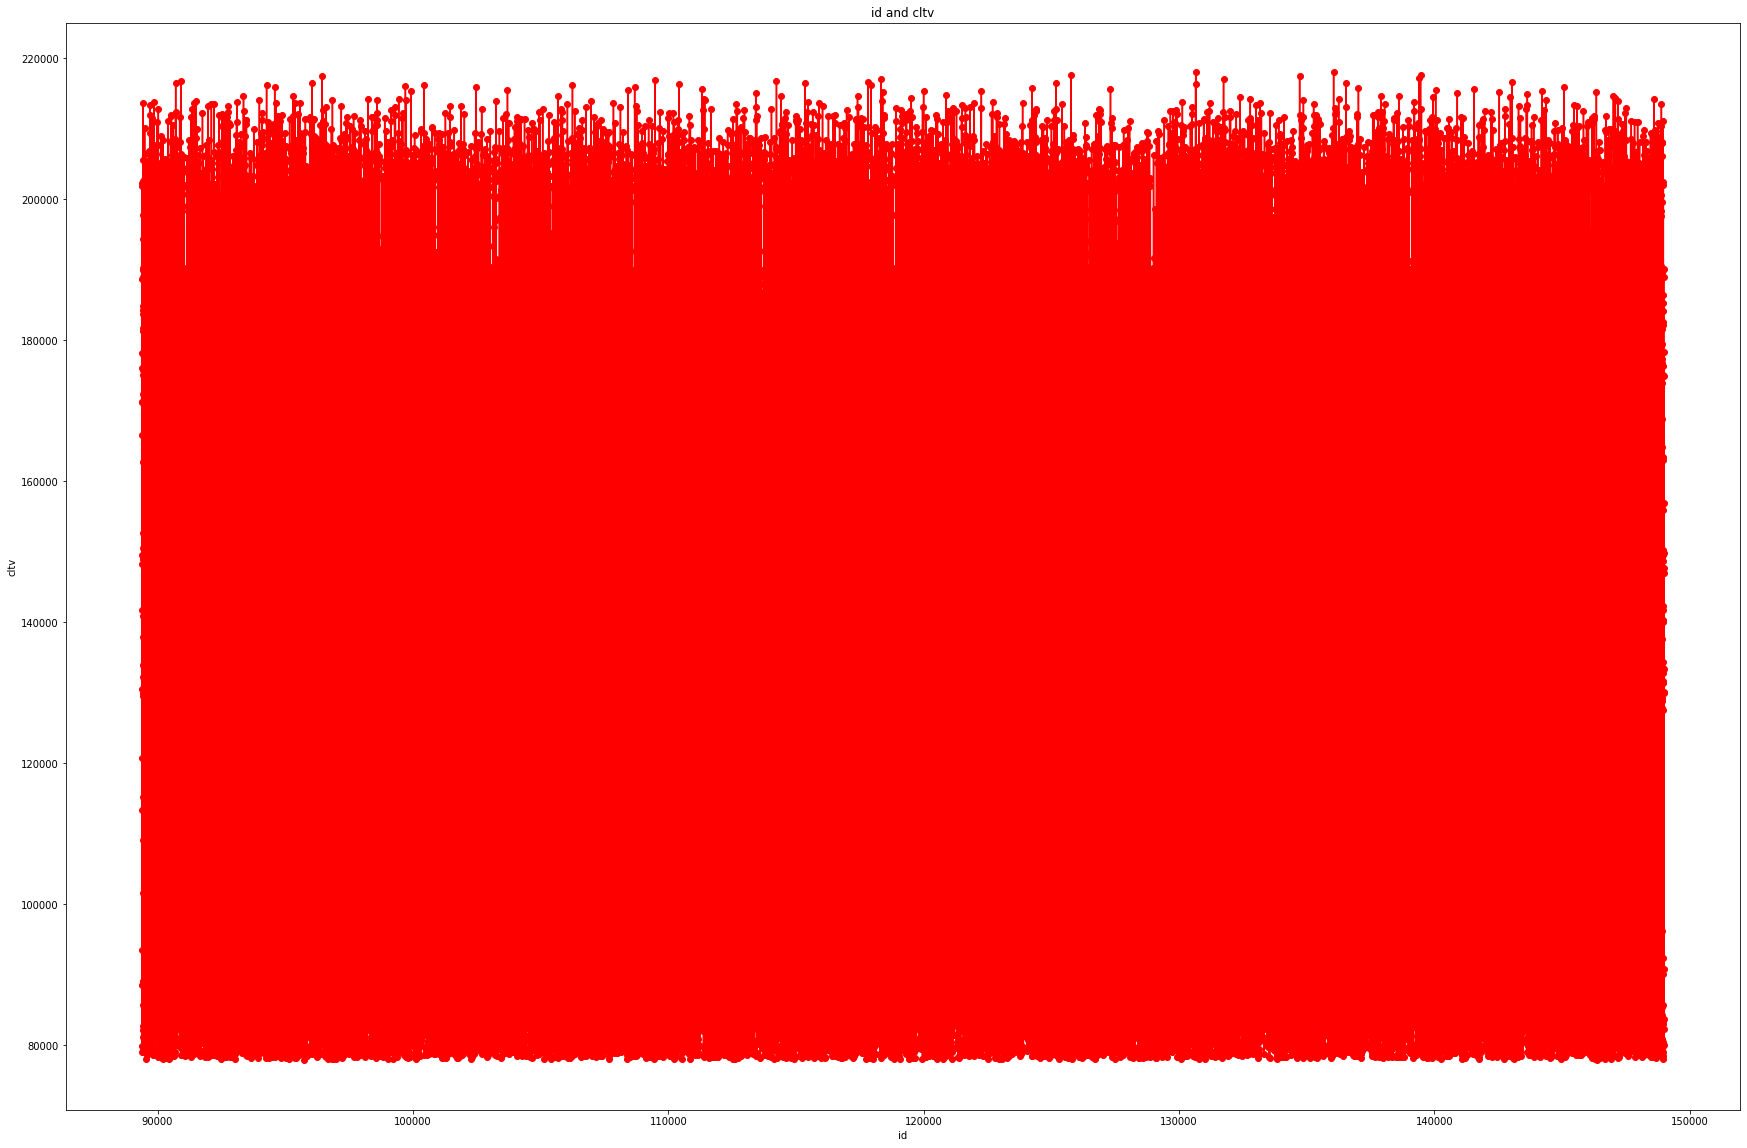

In [42]:
x_axis=submission['id']
y_axis=submission['cltv']
plt.plot(x_axis, y_axis, color='red', marker='o')
plt.title('id and cltv')
plt.xlabel('id')
plt.ylabel('cltv')
plt.rcParams["figure.figsize"] = (30,20)
plt.show()